# Model calibration
Probability calibration is the process of calibrating an ML model to return the true likelihood of an event. This is necessary when we need the probability of the event in question rather than its classification. For example, when comparing two classifiers, it is helpful look at the confidence level of both models even they return same predicted label.

## Dataset
Sythetic binary classification data with 100000 samples and 15 features is created. Of the 15 features, only 2 are informative, 2 are redundant (random combinations of the informative features) and the remaining 11 are uninformative (random numbers). Of the 100,000 samples, 2000 will be used for model fitting and the remaining for testing.

In [64]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features= 15, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 1000  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

## Calibration curves

The perfectly calibrated line of an ideal model is a line having slope +1. A model is perfectly calibrated if, for any p, a prediction of a class with confidence p is correct 100*p% of the time. Saying in another word, calibration curves are created by binning the predicted probablities, then plotting the mean predicted probablities in each bin against the observed positive frequency.

In [65]:
import numpy as np
from sklearn.svm import LinearSVC

class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba


In [66]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

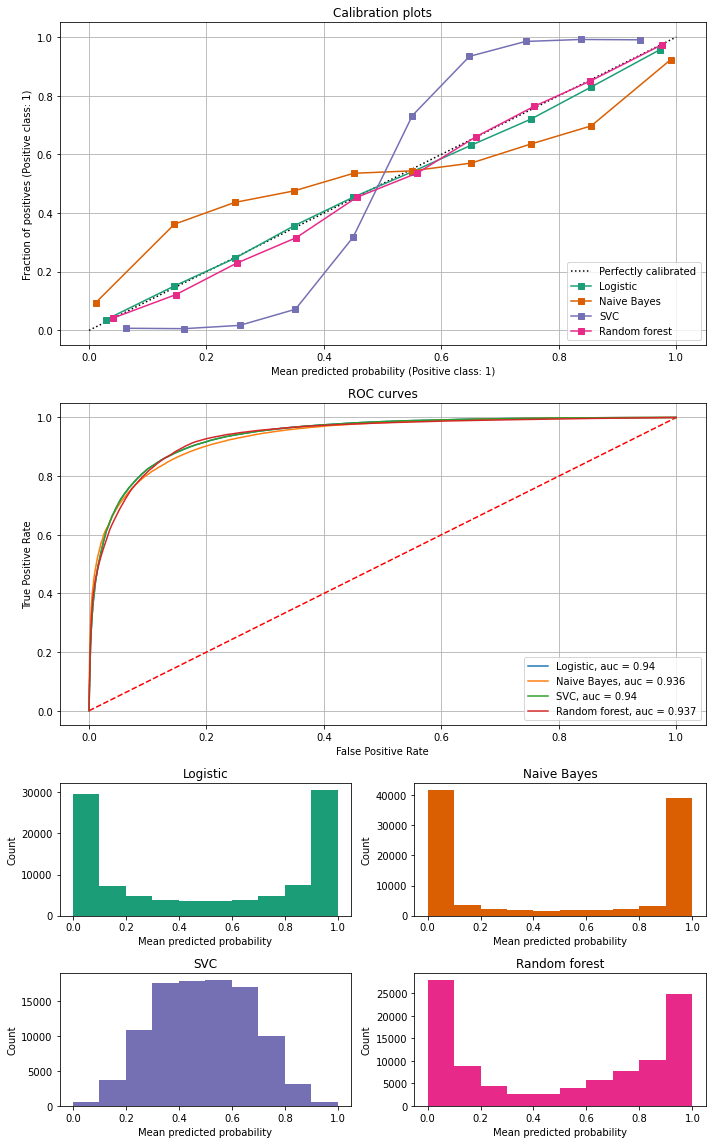

In [67]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn import metrics

# create the figure and specify grid 
fig = plt.figure(figsize=(10, 16))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("Dark2")

# Add calibration curve
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add ROC curve
roc_curve = fig.add_subplot(gs[2:4, :2])
roc_curve.plot([0, 1], [0, 1],'r--')
for _, (clf, name) in enumerate(clf_list):
    #row, col = grid_positions[i]
    #ax = fig.add_subplot(gs[row, col])
    
    clf.fit(X_train, y_train)
    if name == 'SVC':
        prob = clf.decision_function(X_test)
    else:
        prob = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, prob)
    auc = metrics.roc_auc_score(y_test, prob)
    roc_curve.plot(fpr, tpr, label= name+f', auc = {str(round(auc,3))}')
    
roc_curve.grid()
roc_curve.legend()
roc_curve.set(title = "ROC curves", xlabel="False Positive Rate", ylabel = "True Positive Rate")
# Add histogram to the rest space in the grid
grid_positions = [(4, 0), (4, 1), (5, 0), (5, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Calibrating classifier
Calibrating a classifier consists of fitting a regressor (called a calibrator) that maps the output of the classifier (as given by decision_function or predict_proba) to a calibrated probability in [0, 1]. Denoting the output of the classifier for a given sample by f_i, the calibrator tries to predict P(y_i=1|f_i).

The samples that are used to fit the calibrator should **not** be the same samples used to fit the classifier, as this would introduce bias. This is because performance of the classifier on its **training data** would be better than for novel data. Using the classifier output of training data to fit the calibrator would thus result in a **biased calibrator** that maps to probabilities closer to 0 and 1 than it should.

 ### Calibration types
There are two arguments of the function we have to consider: the methods and the validations:

Two methods of calibration:
- Sigmoid scaling or Platt’s method. This is suitable for models with a sigmoid curve (like RFC) and it works well with small datasets. Some algorithms have inbuilt Platt calibration, like SVC()
- Isotonic regression — a non-parametric approach. It is a more powerful calibration method but it tends to overfit and is not advised for small datasets. Isotonic regression fits a non-decreasing real piecewise linear function to 1-dimensional data by producing y_hat for the training data which are closest to target, using function sklearn.isotonic.IsotonicRegression().

Two possible validations:
- Before, using classical cross validation
- After the model is trained using “prefit” model by setting cv=prefit. This is usually more suitable for larger datasets.

In [72]:
from sklearn.calibration import CalibratedClassifierCV
# Create calibrators
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()

lr_calibrator = CalibratedClassifierCV(lr, cv=3)
gnb_calibrator = CalibratedClassifierCV(gnb, cv=3)
svc_calibrator = CalibratedClassifierCV(svc, cv=3)
rfc_calibrator = CalibratedClassifierCV(rfc, cv=3)

In [74]:
calibrator_list = [
    (lr_calibrator, "Calibrated Logistic"),
    (gnb_calibrator, "Calibrated Naive Bayes"),
    (svc_calibrator, "Calibrated SVC"),
    (rfc_calibrator, "Calibrated Random forest"),
]

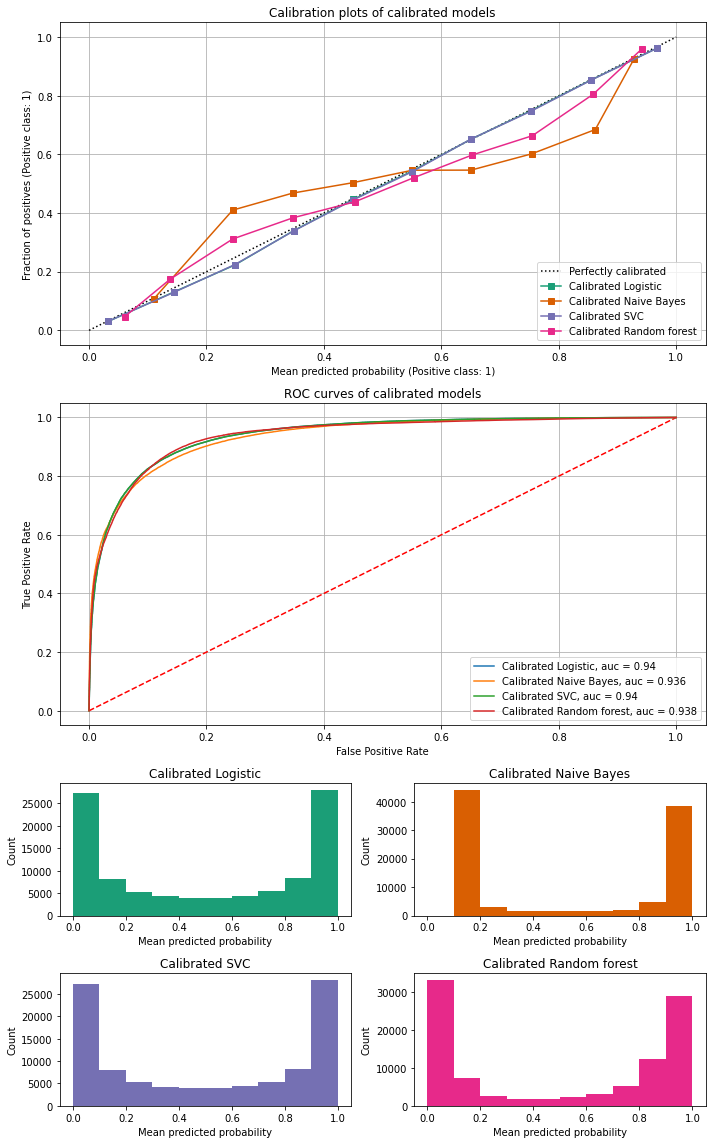

In [75]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn import metrics

# create the figure and specify grid 
fig = plt.figure(figsize=(10, 16))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("Dark2")

# Add calibration curve
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(calibrator_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots of calibrated models")

# Add ROC curve
roc_curve = fig.add_subplot(gs[2:4, :2])
roc_curve.plot([0, 1], [0, 1],'r--')
for _, (clf, name) in enumerate(calibrator_list):
    clf.fit(X_train, y_train)
    if name == 'SVC':
        prob = clf.decision_function(X_test)
    else:
        prob = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, prob)
    auc = metrics.roc_auc_score(y_test, prob)
    roc_curve.plot(fpr, tpr, label= name+f', auc = {str(round(auc,3))}')
    
roc_curve.grid()
roc_curve.legend()
roc_curve.set(title = "ROC curves of calibrated models", xlabel="False Positive Rate", ylabel = "True Positive Rate")

# Add histogram to the rest space in the grid
grid_positions = [(4, 0), (4, 1), (5, 0), (5, 1)]
for i, (_, name) in enumerate(calibrator_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

After calibration, LinearSVC has been calibrated very well, the histogram plot of SVC has been squashed to a bathtub curve. The ROC of the models haven't changed a lot.